In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV
import pickle
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.cloud import storage
import json
# from sklearn.ensemble import CatBoostClassifier

In [2]:
client = bigquery.Client()

print("Client creating using default project: {}".format(client.project))
query = """
 select * from `jm-ebg.EDA_MODEL.lable_data_with_extra_features`
 """
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    # location="US",
)  # API request - starts the query
df = query_job.to_dataframe()
df.shape
# df.to_csv('train_data.csv')

Client creating using default project: jm-ebg


(102571, 28)

In [3]:
cat_cols = list(df.select_dtypes(include=['O']).columns)
float_cols = list(df.select_dtypes(include=[float]).columns)
int_cols = list(df.select_dtypes(include=[int]).columns)
int_cols.remove('label')

In [4]:
data={}
unwanted = {'(none)','(direct)','(not set)','(Other)'}  

In [5]:
def analysis_count(column_name,number):
    return df.groupby([column_name])[column_name].size().reset_index(name='count') \
                     .sort_values(['count'], ascending=False) \
                     .head(number).reset_index(drop=True)
def analysis_column(column_name,number):
    return df.groupby([column_name])[column_name].size().reset_index(name='count') \
                     .sort_values(['count'], ascending=False) \
                     .head(number)[column_name].tolist()

In [6]:
##data -> dictionary 
# data['placement'] =  analysis_column("placement",150)
# data['placement'] = [i for i in data['placement']  if i not in unwanted]
data['device_category_past'] =  analysis_column('device_category_past',4)
data['device_category_past'] = [i for i in data['device_category_past']  if i not in unwanted] 
data['mobile_brand_name_past'] =  analysis_column('mobile_brand_name_past',10)
data['mobile_brand_name_past'] = [i for i in data['mobile_brand_name_past']  if i not in unwanted] 
data['operating_system_past'] =  analysis_column('operating_system_past',5)
data['operating_system_past'] = [i for i in data['operating_system_past']  if i not in unwanted] 
data['os_version_past'] =  analysis_column('os_version_past',10)
data['os_version_past'] = [i for i in data['os_version_past']  if i not in unwanted] 
data['browser_past'] =  analysis_column('browser_past',8)
data['browser_past'] = [i for i in data['browser_past']  if i not in unwanted]
data['city_past'] =  analysis_column('city_past',160)
data['city_past'] = [i for i in data['city_past']  if i not in unwanted]
data['region_past'] =  analysis_column('region_past',50)
data['region_past'] = [i for i in data['region_past']  if i not in unwanted] 
data['ft_campaign_past'] =  analysis_column('ft_campaign_past',70)
data['ft_campaign_past'] = [i for i in data['ft_campaign_past']  if i not in unwanted]
data['ft_medium_past'] =  analysis_column('ft_medium_past',5)
data['ft_medium_past'] = [i for i in data['ft_medium_past']  if i not in unwanted] 
data['ft_source_past'] =  analysis_column('ft_source_past',10)
data['ft_source_past'] = [i for i in data['ft_source_past']  if i not in unwanted] 
data['utm_term_placement_past'] =  analysis_column('utm_term_placement_past',200)
data['utm_term_placement_past'] = [i for i in data['utm_term_placement_past']  if i not in unwanted]
# data['placement_past'] =  analysis_column('placement_past',150)
# data['placement_past'] = [i for i in data['placement_past']  if i not in unwanted]

In [7]:
# df['placement'].loc[df['placement'].apply(lambda x: (x not in data['placement']) )] = '(Others)'
df['device_category_past'].loc[df['device_category_past'].apply(lambda x: (x not in data['device_category_past']) )] = '(Others)'
df['mobile_brand_name_past'].loc[df['mobile_brand_name_past'].apply(lambda x: (x not in data['mobile_brand_name_past']) )] = '(Others)'
df['operating_system_past'].loc[df['operating_system_past'].apply(lambda x: (x not in data['operating_system_past']) )] = '(Others)'
df['os_version_past'].loc[df['os_version_past'].apply(lambda x: (x not in data['os_version_past']) )] = '(Others)'
df['browser_past'].loc[df['browser_past'].apply(lambda x: (x not in data['browser_past']) )] = '(Others)'
df['city_past'].loc[df['city_past'].apply(lambda x: (x not in data['city_past']) )] = '(Others)'
df['region_past'].loc[df['region_past'].apply(lambda x: (x not in data['region_past']) )] = '(Others)'
df['ft_campaign_past'].loc[df['ft_campaign_past'].apply(lambda x: (x not in data['ft_campaign_past']) )] = '(Others)'
df['ft_medium_past'].loc[df['ft_medium_past'].apply(lambda x: (x not in data['ft_medium_past']) )] = '(Others)'
df['ft_source_past'].loc[df['ft_source_past'].apply(lambda x: (x not in data['ft_source_past']) )] = '(Others)'
df['utm_term_placement_past'].loc[df['utm_term_placement_past'].apply(lambda x: (x not in data['utm_term_placement_past']) )] = '(Others)'
# df['placement_past'].loc[df['placement_past'].apply(lambda x: (x not in data['placement_past']) )] = '(Others)'

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
### replace the string int and float value
for i in cat_cols:
    df[i].fillna("Value_Not_Found", inplace = True)
for i in int_cols:
    df[i].fillna(-99999, inplace = True) 
for i in float_cols:
    df[i].fillna(-99999999.000, inplace = True) 

In [9]:
df.head()

ProspectId         user_pseudo_id  \
0  00d2aaa0-69b1-4b8f-89b8-e5f9b53a8b6a   711925274.1675325695   
1  01304386-f4b0-4601-ba81-097b966095fe  2061620715.1671277346   
2  019e7323-c132-4cf3-b97e-048b84ed435a   222679061.1675254861   
3  01fbcabe-8ce6-4234-8ee6-e616fdf22136  1529146629.1673193933   
4  0294d226-f9e7-4ebe-a176-2f7cb5eae5ed  1396493678.1675044228   

   visitStartTime event_date  timeOnSite_past  day_of_week_past  \
0      1675325695   20230202         0.682301                 5   
1      1675582360   20230205        35.725837                 1   
2      1675254861   20230201         0.462754                 4   
3      1677211898   20230224        24.002012                 6   
4      1678425248   20230310         4.844952                 6   

  device_category_past mobile_brand_name_past operating_system_past  \
0              desktop               (Others)               Windows   
1               mobile                   OPPO               Android   
2               mobile                 Realme               Android   
3               mobile                   Vivo               Android   
4               mobile                   Vivo               Android   

  os_version_past  ...  ProspectId_conv visitStartTime_conv        date_conv  \
0        (Others)  ...  Value_Not_Found              -99999  Value_Not_Found   
1      Android 12  ...  Value_Not_Found              -99999  Value_Not_Found   
2      Android 11  ...  Value_Not_Found              -99999  Value_Not_Found   
3      Android 11  ...  Value_Not_Found              -99999  Value_Not_Found   
4  Android 12.0.0  ...  Value_Not_Found              -99999  Value_Not_Found   

  day_diff label               ProspectID_LeadCreation  \
0   -99999     0  00d2aaa0-69b1-4b8f-89b8-e5f9b53a8b6a   
1   -99999     0  01304386-f4b0-4601-ba81-097b966095fe   
2   -99999     0  019e7323-c132-4cf3-b97e-048b84ed435a   
3   -99999     0  01fbcabe-8ce6-4234-8ee6-e616fdf22136   
4   -99999     0  0294d226-f9e7-4ebe-a176-2f7cb5eae5ed   

        mx_Last_Activity_Notes      ProspectActivityName_Max  \
0                         busy               Not Contactable   
1  call disconnected by client  Outbound Phone Call Activity   
2                         busy  Outbound Phone Call Activity   
3                    intrested  Outbound Phone Call Activity   
4                    call drop               Not Contactable   

  mx_Last_Activity_done_by_Agent  \
0                Not Contactable   
1                Not Contactable   
2                Not Contactable   
3                      Call Back   
4                Not Contactable   

                                mx_Sub_Dispostion  
0                                          Others  
1  Call Disconnected By Client - No Communication  
2                                          Others  
3                                       intrested  
4  Call Disconnected By Client - No Communication  

[5 rows x 28 columns]

In [10]:
#categorical value handling
le = LabelEncoder()
for  i in cat_cols:
    df[i] = le.fit_transform(df[i])
    pickle.dump(le, open("label_encode/{}-esd-RF.pkl".format(i), 'wb'))

In [11]:
drop_cols = ['visitStartTime', 'event_date',
       'mx_Last_Activity_Notes']
df = df.drop(drop_cols, axis=1)

In [12]:
drop_cols = ['ProspectId','user_pseudo_id']
df = df.drop(drop_cols, axis=1)

<AxesSubplot:xlabel='label', ylabel='mx_Last_Activity_done_by_Agent'>

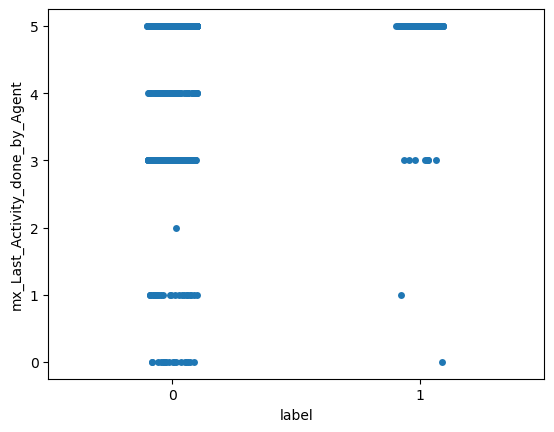

In [165]:
import seaborn as sns
sns.stripplot(df, x="label", y="mx_Last_Activity_done_by_Agent")


<AxesSubplot:xlabel='label', ylabel='ProspectActivityName_Max'>

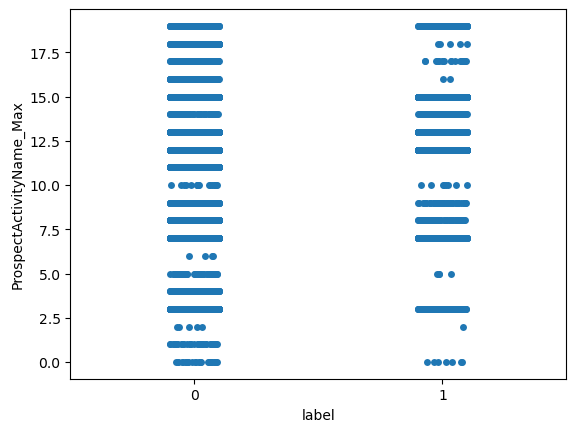

In [14]:
import seaborn as sns
sns.stripplot(df, x="label", y="ProspectActivityName_Max")

In [15]:
df = df.astype(float)

In [ ]:
g = sns.pairplot(df.sample(1000), hue="label")

In [16]:
df.dtypes

timeOnSite_past                   float64
day_of_week_past                  float64
device_category_past              float64
mobile_brand_name_past            float64
operating_system_past             float64
os_version_past                   float64
browser_past                      float64
region_past                       float64
city_past                         float64
ft_campaign_past                  float64
ft_medium_past                    float64
ft_source_past                    float64
utm_term_placement_past           float64
label                             float64
ProspectActivityName_Max          float64
mx_Last_Activity_done_by_Agent    float64
mx_Sub_Dispostion                 float64
dtype: object

KeyboardInterrupt: 

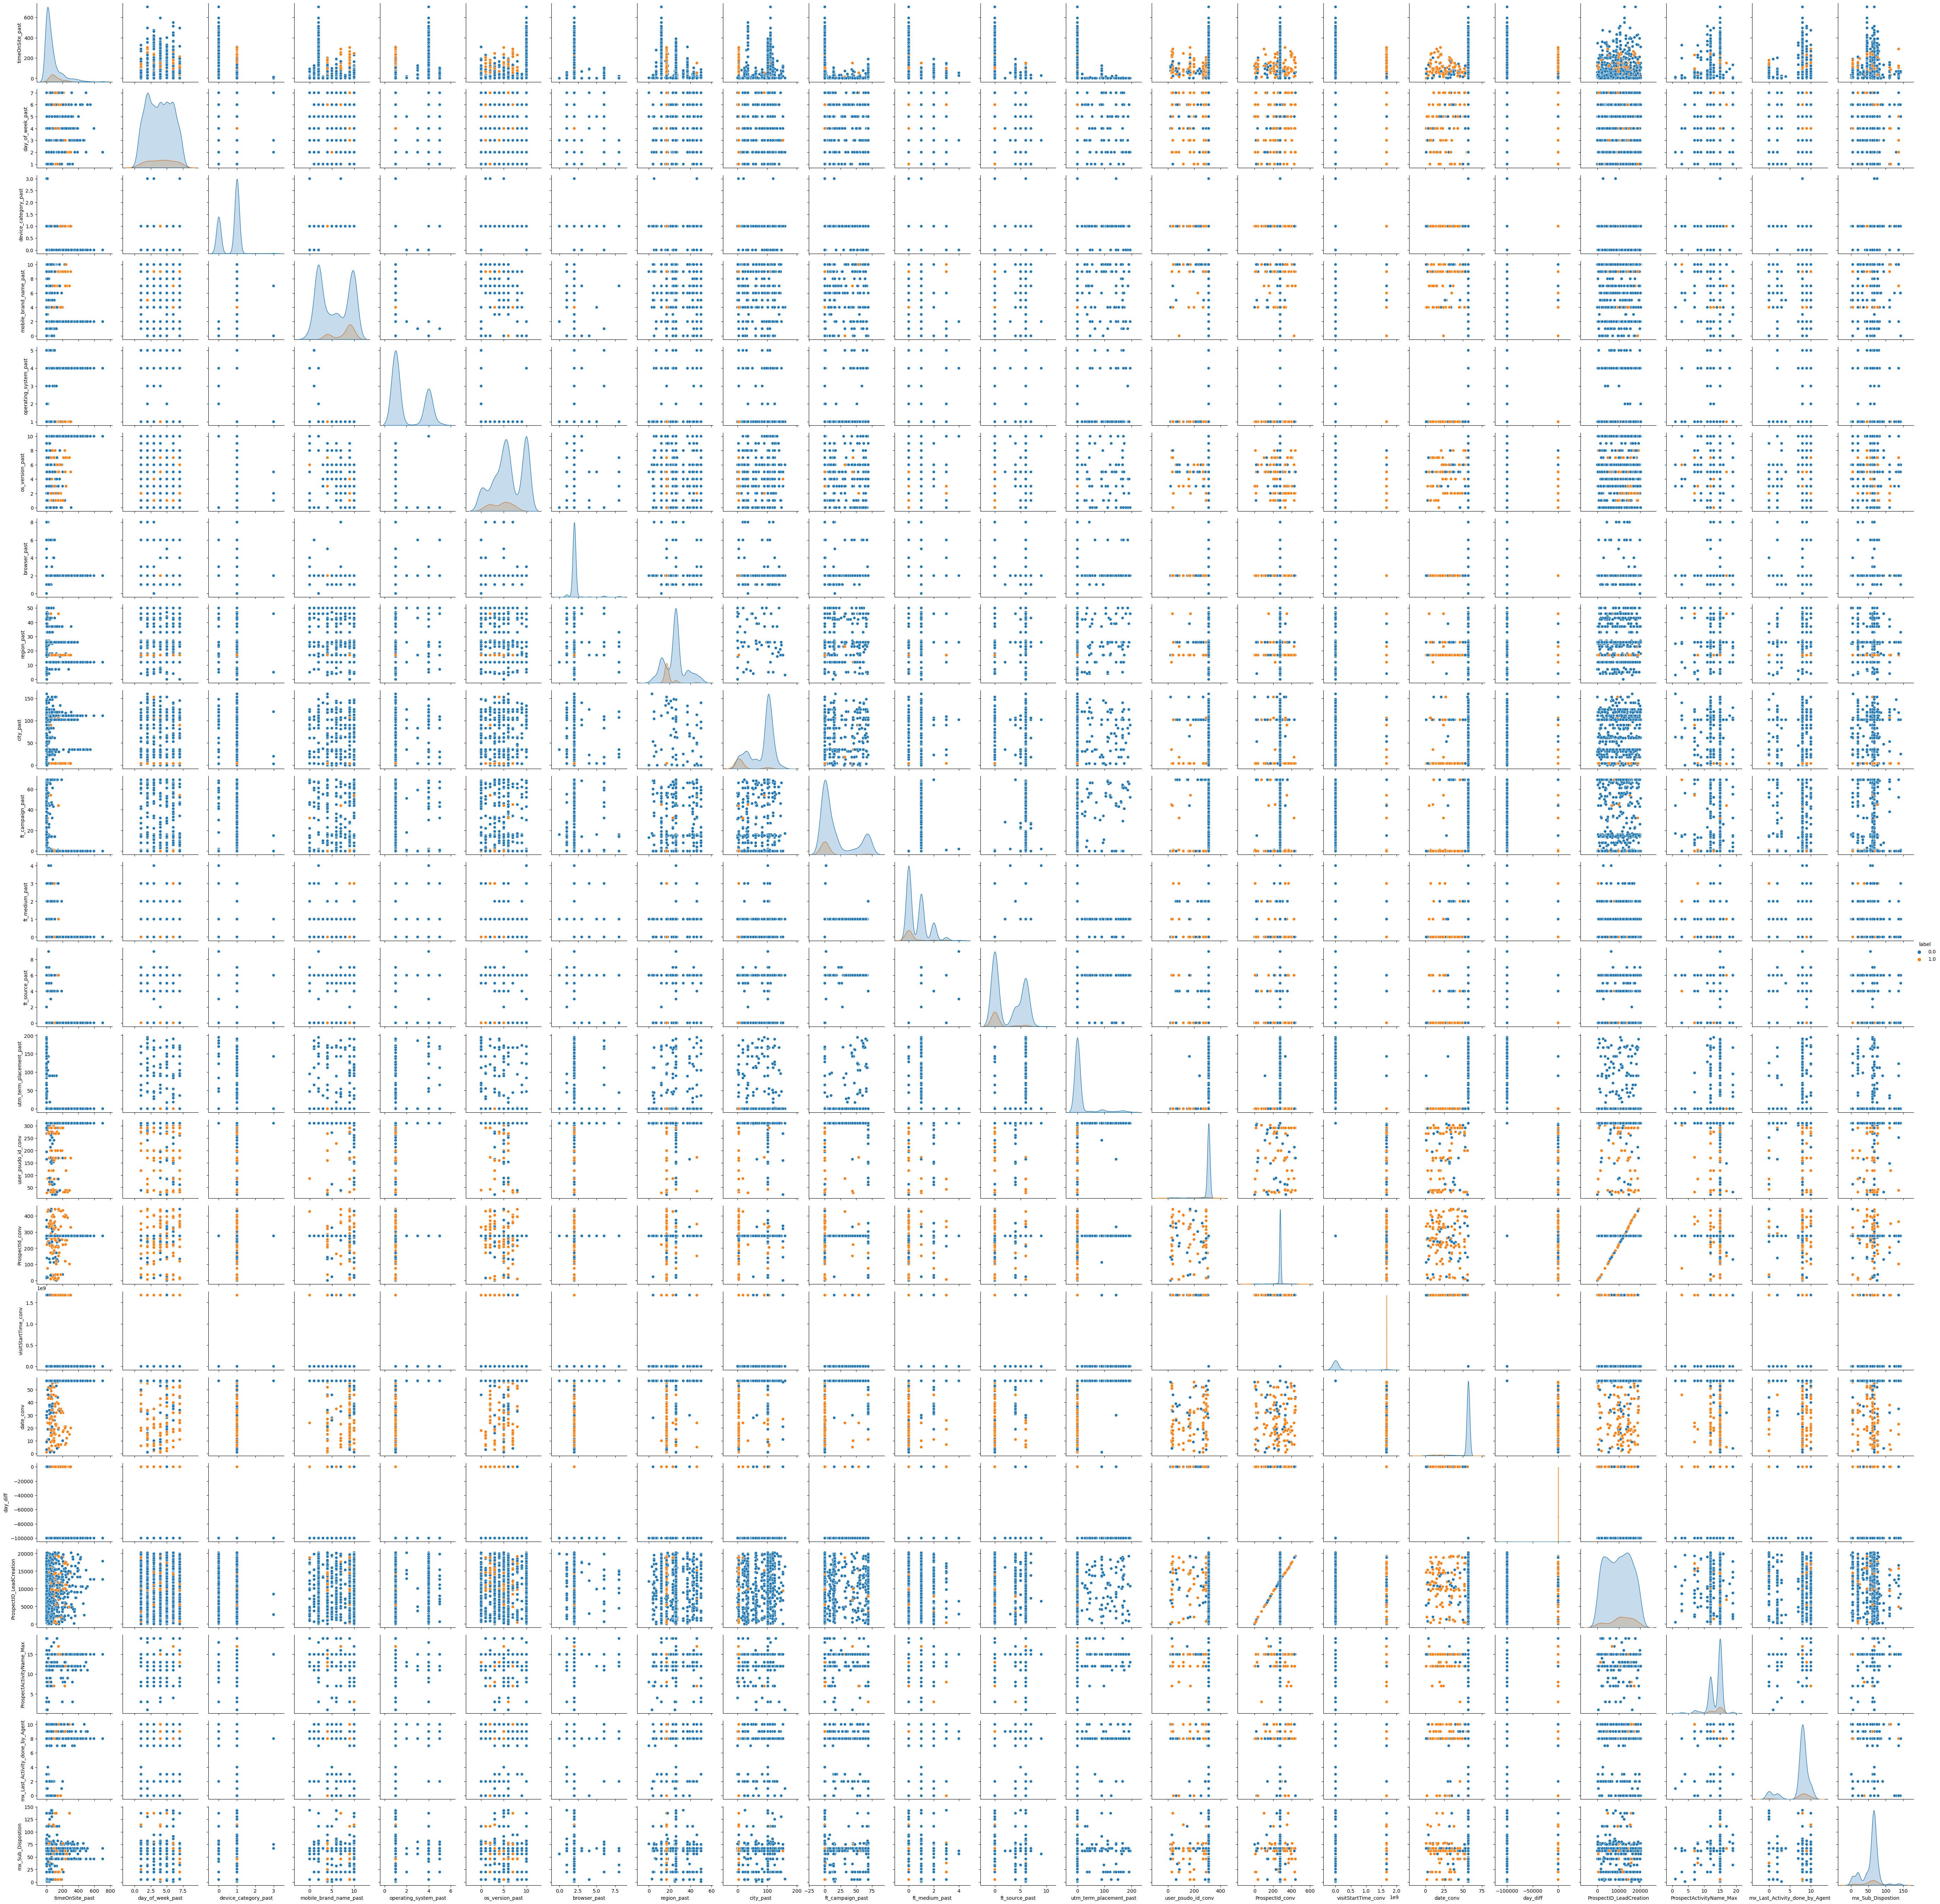

In [56]:
sns.pairplot(df.sample(1000), hue="label",diag_kind='kde')

In [13]:
df=df.astype(float)

In [14]:
df.head()

timeOnSite_past  day_of_week_past  device_category_past  \
0         0.682301               5.0                   0.0   
1        35.725837               1.0                   1.0   
2         0.462754               4.0                   1.0   
3        24.002012               6.0                   1.0   
4         4.844952               6.0                   1.0   

   mobile_brand_name_past  operating_system_past  os_version_past  \
0                     0.0                    4.0              0.0   
1                     4.0                    1.0              5.0   
2                     6.0                    1.0              3.0   
3                     9.0                    1.0              3.0   
4                     9.0                    1.0              6.0   

   browser_past  region_past  city_past  ft_campaign_past  ...  \
0           5.0         46.0        3.0              48.0  ...   
1           2.0         26.0      102.0               0.0  ...   
2           2.0         42.0       32.0              39.0  ...   
3           2.0         43.0       61.0              65.0  ...   
4           2.0         26.0      102.0               0.0  ...   

   user_psudo_id_conv  ProspectId_conv  visitStartTime_conv  date_conv  \
0               310.0            276.0             -99999.0       57.0   
1               310.0            276.0             -99999.0       57.0   
2               310.0            276.0             -99999.0       57.0   
3               310.0            276.0             -99999.0       57.0   
4               310.0            276.0             -99999.0       57.0   

   day_diff  label  ProspectID_LeadCreation  ProspectActivityName_Max  \
0  -99999.0    0.0                     72.0                      12.0   
1  -99999.0    0.0                    110.0                      15.0   
2  -99999.0    0.0                    145.0                      15.0   
3  -99999.0    0.0                    170.0                      15.0   
4  -99999.0    0.0                    209.0                      12.0   

   mx_Last_Activity_done_by_Agent  mx_Sub_Dispostion  
0                             8.0               62.0  
1                             8.0               20.0  
2                             8.0               62.0  
3                             2.0              113.0  
4                             8.0               20.0  

[5 rows x 23 columns]

In [15]:
df['day_of_week_past'].corr(df['label'])

0.016296403034019802

In [16]:
df['timeOnSite_past'].corr(df['label'])

0.10387954433913317

In [17]:
df['device_category_past'].corr(df['label'])

0.2145535044270356

In [18]:
df['mobile_brand_name_past'].corr(df['label'])

0.22218526786013684

In [19]:
df['operating_system_past'].corr(df['label'])

-0.22990477271614007

In [20]:
df['os_version_past'].corr(df['label'])

-0.1771553295578652

In [21]:
df['browser_past'].corr(df['label'])

-0.037785275809568496

In [22]:
df['region_past'].corr(df['label'])

-0.19066197220968162

In [23]:
df['city_past'].corr(df['label'])

-0.41354313195686054

In [24]:
df['ft_campaign_past'].corr(df['label'])

-0.13463492211111666

In [25]:
df['ft_medium_past'].corr(df['label'])

-0.15486387264144716

In [26]:
df['ft_source_past'].corr(df['label'])

-0.22307464842188376

In [27]:
df['utm_term_placement_past'].corr(df['label'])

-0.08743834351498127

In [28]:
df['ProspectActivityName_Max'].corr(df['label'])

0.03778112190136822

In [29]:
df['mx_Last_Activity_done_by_Agent'].corr(df['label'])

-0.0003760875791622383

In [30]:
df['mx_Sub_Dispostion'].corr(df['label'])

-0.007326407819818407

In [31]:
df.head()

timeOnSite_past  day_of_week_past  device_category_past  \
0         0.682301               5.0                   0.0   
1        35.725837               1.0                   1.0   
2         0.462754               4.0                   1.0   
3        24.002012               6.0                   1.0   
4         4.844952               6.0                   1.0   

   mobile_brand_name_past  operating_system_past  os_version_past  \
0                     0.0                    4.0              0.0   
1                     4.0                    1.0              5.0   
2                     6.0                    1.0              3.0   
3                     9.0                    1.0              3.0   
4                     9.0                    1.0              6.0   

   browser_past  region_past  city_past  ft_campaign_past  ...  \
0           5.0         46.0        3.0              48.0  ...   
1           2.0         26.0      102.0               0.0  ...   
2           2.0         42.0       32.0              39.0  ...   
3           2.0         43.0       61.0              65.0  ...   
4           2.0         26.0      102.0               0.0  ...   

   user_psudo_id_conv  ProspectId_conv  visitStartTime_conv  date_conv  \
0               310.0            276.0             -99999.0       57.0   
1               310.0            276.0             -99999.0       57.0   
2               310.0            276.0             -99999.0       57.0   
3               310.0            276.0             -99999.0       57.0   
4               310.0            276.0             -99999.0       57.0   

   day_diff  label  ProspectID_LeadCreation  ProspectActivityName_Max  \
0  -99999.0    0.0                     72.0                      12.0   
1  -99999.0    0.0                    110.0                      15.0   
2  -99999.0    0.0                    145.0                      15.0   
3  -99999.0    0.0                    170.0                      15.0   
4  -99999.0    0.0                    209.0                      12.0   

   mx_Last_Activity_done_by_Agent  mx_Sub_Dispostion  
0                             8.0               62.0  
1                             8.0               20.0  
2                             8.0               62.0  
3                             2.0              113.0  
4                             8.0               20.0  

[5 rows x 23 columns]

In [32]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import BalancedBaggingClassifier

In [33]:
df['label'].value_counts()

0.0    91004
1.0    11567
Name: label, dtype: int64

In [34]:
A=df.drop(['label','utm_term_placement_past','ft_source_past','ft_medium_past','ft_campaign_past','city_past','region_past','browser_past','os_version_past','operating_system_past','mx_Last_Activity_done_by_Agent','mx_Sub_Dispostion'],axis=1)

In [35]:
B=df.drop(['label','day_of_week_past','ProspectActivityName_Max','timeOnSite_past','device_category_past','mobile_brand_name_past'],axis=1)

In [36]:
A.head()

timeOnSite_past  day_of_week_past  device_category_past  \
0         0.682301               5.0                   0.0   
1        35.725837               1.0                   1.0   
2         0.462754               4.0                   1.0   
3        24.002012               6.0                   1.0   
4         4.844952               6.0                   1.0   

   mobile_brand_name_past  user_psudo_id_conv  ProspectId_conv  \
0                     0.0               310.0            276.0   
1                     4.0               310.0            276.0   
2                     6.0               310.0            276.0   
3                     9.0               310.0            276.0   
4                     9.0               310.0            276.0   

   visitStartTime_conv  date_conv  day_diff  ProspectID_LeadCreation  \
0             -99999.0       57.0  -99999.0                     72.0   
1             -99999.0       57.0  -99999.0                    110.0   
2             -99999.0       57.0  -99999.0                    145.0   
3             -99999.0       57.0  -99999.0                    170.0   
4             -99999.0       57.0  -99999.0                    209.0   

   ProspectActivityName_Max  
0                      12.0  
1                      15.0  
2                      15.0  
3                      15.0  
4                      12.0

In [37]:
X = df.drop(['label'], axis=1)
y = df.label

In [38]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.25, stratify=y)

In [39]:
A_train, A_test, y_train, y_test=train_test_split(A, y, test_size=.25, stratify=y)

In [40]:
B_train, B_test, y_train, y_test=train_test_split(B, y, test_size=.25, stratify=y)

In [53]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


ss_train = RobustScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = RobustScaler()
X_test = ss_test.fit_transform(X_test)
X=ss_test.fit_transform(X)

In [42]:
ss_train = QuantileTransformer()
A_train = ss_train.fit_transform(A_train)

ss_test = QuantileTransformer()
A_test = ss_test.fit_transform(A_test)

In [43]:
ss_train = QuantileTransformer()
B_train = ss_train.fit_transform(B_train)

ss_test = QuantileTransformer()
B_test = ss_test.fit_transform(B_test)

In [54]:
bbc = BalancedBaggingClassifier(random_state=69)
bbc.fit(X_train, y_train)
BalancedBaggingClassifier(...)
y_pred = bbc.predict(X_test)

In [51]:
bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(A_train, y_train)
BalancedBaggingClassifier(...)
y_pred = bbc.predict(A_test)

In [46]:
bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(B_train, y_train)
BalancedBaggingClassifier(...)
y_pred = bbc.predict(B_test)

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

y_pred = bbc.predict(X_test)
#y_pred = [1 if val >= 0.50 else 0 for val in y_pred_prob[:,1]]
f1 = f1_score(y_test, y_pred)
print("accuracy : ", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("roc auc : ", roc_auc_score(y_test, y_pred))
print("recall : ", recall_score(y_test, y_pred))
print("precision : ", precision_score(y_test, y_pred))
print("f1 score : ",f1 )

print ("----------------------")

accuracy :  0.7138400343173575
[[17684  5067]
 [ 2271   621]]
roc auc :  0.49600740271140326
recall :  0.21473029045643152
precision :  0.10917721518987342
f1 score :  0.14475524475524476
----------------------


In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

y_pred = bbc.predict(A_test)
#y_pred = [1 if val >= 0.50 else 0 for val in y_pred_prob[:,1]]
f1 = f1_score(y_test, y_pred)
print("accuracy : ", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("roc auc : ", roc_auc_score(y_test, y_pred))
print("recall : ", recall_score(y_test, y_pred))
print("precision : ", precision_score(y_test, y_pred))
print("f1 score : ",f1 )

print ("----------------------")

accuracy :  0.7047537339624849
[[17403  5348]
 [ 2223   669]]
roc auc :  0.49813060517516805
recall :  0.23132780082987553
precision :  0.1111849759016121
f1 score :  0.15018520597148952
----------------------


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

y_pred = bbc.predict(B)
#y_pred = [1 if val >= 0.50 else 0 for val in y_pred_prob[:,1]]
f1 = f1_score(y, y_pred)
print("accuracy : ", accuracy_score(y, y_pred))
print(confusion_matrix(y, y_pred))
print("roc auc : ", roc_auc_score(y, y_pred))
print("recall : ", recall_score(y, y_pred))
print("precision : ", precision_score(y, y_pred))
print("f1 score : ",f1 )

print ("----------------------")

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


accuracy :  0.8872293338273001
[[91004     0]
 [11567     0]]
roc auc :  0.5
recall :  0.0
precision :  0.0
f1 score :  0.0
----------------------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [211]:
filename = 'model/Dhawal_blagging.pkl'

pickle.dump(bbc, open(filename, 'wb'))

In [153]:
bbc.features_in_

AttributeError: 'BalancedBaggingClassifier' object has no attribute 'features_in_'